# 第三章 PyTorch基础：Tensor和Autograd

## 3.1 Tensor

Tensor，又名张量，读者可能对这个名词似曾相识，因它不仅在PyTorch中出现过，它也是Theano、TensorFlow、
Torch和MxNet中重要的数据结构。关于张量的本质不乏深度的剖析，但从工程角度来讲，可简单地认为它就是一个数组，且支持高效的科学计算。它可以是一个数（标量）、一维数组（向量）、二维数组（矩阵）和更高维的数组（高阶数据）。Tensor和Numpy的ndarrays类似，但PyTorch的tensor支持GPU加速。

本节将系统讲解tensor的使用，力求面面俱到，但不会涉及每个函数。对于更多函数及其用法，读者可通过在IPython/Notebook中使用函数名加`?`查看帮助文档，或查阅PyTorch官方文档[^1]。

[^1]: http://docs.pytorch.org

In [1]:
# Let's begin
from __future__ import print_function
import torch  as t
t.__version__

'0.4.0'

###  3.1.1 基础操作

学习过Numpy的读者会对本节内容感到非常熟悉，因tensor的接口有意设计成与Numpy类似，以方便用户使用。但不熟悉Numpy也没关系，本节内容并不要求先掌握Numpy。

从接口的角度来讲，对tensor的操作可分为两类：

1. `torch.function`，如`torch.save`等。
2. 另一类是`tensor.function`，如`tensor.view`等。

为方便使用，对tensor的大部分操作同时支持这两类接口，在本书中不做具体区分，如`torch.sum (torch.sum(a, b))`与`tensor.sum (a.sum(b))`功能等价。

而从存储的角度来讲，对tensor的操作又可分为两类：

1. 不会修改自身的数据，如 `a.add(b)`， 加法的结果会返回一个新的tensor。
2. 会修改自身的数据，如 `a.add_(b)`， 加法的结果仍存储在a中，a被修改了。

函数名以`_`结尾的都是inplace方式, 即会修改调用者自己的数据，在实际应用中需加以区分。

#### 创建Tensor

在PyTorch中新建tensor的方法有很多，具体如表3-1所示。

表3-1: 常见新建tensor的方法

|函数|功能|
|:---:|:---:|
|Tensor(\*sizes)|基础构造函数|
|ones(\*sizes)|全1Tensor|
|zeros(\*sizes)|全0Tensor|
|eye(\*sizes)|对角线为1，其他为0|
|arange(s,e,step|从s到e，步长为step|
|linspace(s,e,steps)|从s到e，均匀切分成steps份|
|rand/randn(\*sizes)|均匀/标准分布|
|normal(mean,std)/uniform(from,to)|正态分布/均匀分布|
|randperm(m)|随机排列|

其中使用`Tensor`函数新建tensor是最复杂多变的方式，它既可以接收一个list，并根据list的数据新建tensor，也能根据指定的形状新建tensor，还能传入其他的tensor，下面举几个例子。

In [2]:
# 指定tensor的形状
a = t.Tensor(2, 3)
a # 数值取决于内存空间的状态

tensor([[ 1.1326e+12,  4.5890e-41,  1.1326e+12],
        [ 4.5890e-41,  4.4842e-44,  0.0000e+00]])

In [3]:
# 用list的数据创建tensor
b = t.Tensor([[1,2,3],[4,5,6]])
b

tensor([[ 1.,  2.,  3.],
        [ 4.,  5.,  6.]])

In [4]:
b.tolist() # 把tensor转为list

[[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]]

`tensor.size()`返回`torch.Size`对象，它是tuple的子类，但其使用方式与tuple略有区别

In [5]:
b_size = b.size()
b_size

torch.Size([2, 3])

In [6]:
b.numel() # b中元素总个数，2*3，等价于b.nelement()

6

In [7]:
# 创建一个和b形状一样的tensor
c = t.Tensor(b_size)
# 创建一个元素为2和3的tensor
d = t.Tensor((2, 3))
c, d

(tensor([[ 1.1326e+12,  4.5890e-41,  3.9972e-37],
         [ 0.0000e+00,  1.5935e+12,  4.5890e-41]]), tensor([ 2.,  3.]))

除了`tensor.size()`，还可以利用`tensor.shape`直接查看tensor的形状，`tensor.shape`等价于`tensor.size()`

In [8]:
c.shape

torch.Size([2, 3])

In [9]:
c.shape??

需要注意的是，`t.Tensor(*sizes)`创建tensor时，系统不会马上分配空间，只是会计算剩余的内存是否足够使用，使用到tensor时才会分配，而其它操作都是在创建完tensor之后马上进行空间分配。其它常用的创建tensor的方法举例如下。

In [10]:
t.ones(2, 3)

tensor([[ 1.,  1.,  1.],
        [ 1.,  1.,  1.]])

In [11]:
t.zeros(2, 3)

tensor([[ 0.,  0.,  0.],
        [ 0.,  0.,  0.]])

In [14]:
t.arange(1, 6, 2)

tensor([ 1.,  3.,  5.])

In [15]:
t.linspace(1, 10, 3)

tensor([  1.0000,   5.5000,  10.0000])

In [16]:
t.randn(2, 3)

tensor([[-1.2017,  0.3210,  0.7062],
        [ 1.4358,  0.0442,  0.3356]])

In [18]:
t.randperm(5) # 长度为5的随机排列

tensor([ 3,  2,  1,  4,  0])

In [19]:
t.eye(2, 3) # 对角线为1, 不要求行列数一致

tensor([[ 1.,  0.,  0.],
        [ 0.,  1.,  0.]])

#### 常用Tensor操作

通过`tensor.view`方法可以调整tensor的形状，但必须保证调整前后元素总数一致。`view`不会修改自身的数据，返回的新tensor与源tensor共享内存，也即更改其中的一个，另外一个也会跟着改变。在实际应用中可能经常需要添加或减少某一维度，这时候`squeeze`和`unsqueeze`两个函数就派上用场了。

In [65]:
a = t.arange(0, 6)
a.view(2, 3)

tensor([[ 0.,  1.,  2.],
        [ 3.,  4.,  5.]])

In [66]:
a

tensor([ 0.,  1.,  2.,  3.,  4.,  5.])

In [67]:
b = a.view(-1, 3) # 当某一维为-1的时候，会自动计算它的大小
b

tensor([[ 0.,  1.,  2.],
        [ 3.,  4.,  5.]])

In [68]:
b.shape

torch.Size([2, 3])

In [69]:
b.unsqueeze_(0) # 注意形状，在第1维（下标从0开始）上增加“１”

tensor([[[ 0.,  1.,  2.],
         [ 3.,  4.,  5.]]])

In [70]:
b.shape

torch.Size([1, 2, 3])

In [71]:
b.unsqueeze_(-2) # -2表示倒数第二个维度，并且是在这个位置插入

tensor([[[[ 0.,  1.,  2.]],

         [[ 3.,  4.,  5.]]]])

In [72]:
b.shape

torch.Size([1, 2, 1, 3])

In [73]:
c = b.view(1, 1, 1, 2, 3)
print(c.shape)
c.squeeze_(0) # 压缩第0维的“１”
print(c.shape)

torch.Size([1, 1, 1, 2, 3])
torch.Size([1, 1, 2, 3])


In [74]:
c.squeeze_() # 把所有维度为“1”的压缩
print(c.shape)

torch.Size([2, 3])


In [75]:
a

tensor([ 0.,  1.,  2.,  3.,  4.,  5.])

In [76]:
b

tensor([[[[ 0.,  1.,  2.]],

         [[ 3.,  4.,  5.]]]])

In [77]:
a[1] = 100
b # a修改，b作为view之后的，也会跟着修改

tensor([[[[   0.,  100.,    2.]],

         [[   3.,    4.,    5.]]]])

a b 是同一个对象不同维度方式的表现

`resize`是另一种可用来调整`size`的方法，但与`view`不同，它可以修改tensor的大小。如果新大小超过了原大小，会自动分配新的内存空间，而如果新大小小于原大小，则之前的数据依旧会被保存，看一个例子。

In [78]:
b

tensor([[[[   0.,  100.,    2.]],

         [[   3.,    4.,    5.]]]])

In [79]:
b.resize_(1, 3)
b
# 这里 b 同样也是只显示了 一部分数据，其实其完整的数据还是被保存的

tensor([[   0.,  100.,    2.]])

In [80]:
# 同样的，ab共享内存，b本质没有变，那么a也没有变了
a

tensor([   0.,  100.,    2.,    3.,    4.,    5.])

In [81]:
b.resize_(3, 3) # 旧的数据依旧保存着，多出的大小会分配新空间
b

tensor([[ 0.0000e+00,  1.0000e+02,  2.0000e+00],
        [ 3.0000e+00,  4.0000e+00,  5.0000e+00],
        [ 1.5294e-38,  0.0000e+00,  1.5785e+12]])

In [82]:
a

tensor([   0.,  100.,    2.,    3.,    4.,    5.])

In [84]:
# 为b新创建的空间赋予值
b[2,:] = t.Tensor([1,1,1])

In [85]:
# 此时b的值就变化了
b

tensor([[   0.,  100.,    2.],
        [   3.,    4.,    5.],
        [   1.,    1.,    1.]])

In [86]:
# 但是a和b只共享原来的6个数字，b新创建的部分并不影响a
a

tensor([   0.,  100.,    2.,    3.,    4.,    5.])

In [87]:
# 对ab共有的部分进行修改，那么ab都会有反应
a[0] = 100

In [88]:
b

tensor([[ 100.,  100.,    2.],
        [   3.,    4.,    5.],
        [   1.,    1.,    1.]])

#### 索引操作

Tensor支持与numpy.ndarray类似的索引操作，语法上也类似，下面通过一些例子，讲解常用的索引操作。如无特殊说明，索引出来的结果与原tensor共享内存，也即修改一个，另一个会跟着修改。

In [89]:
a = t.randn(3, 4)
a

tensor([[-0.5449, -0.8211,  1.2699, -0.5329],
        [-1.3744, -1.5667, -0.5754, -0.3414],
        [-0.6316, -0.5624, -0.2114,  0.7638]])

In [90]:
a[0] # 第0行(下标从0开始)

tensor([-0.5449, -0.8211,  1.2699, -0.5329])

In [91]:
a[:, 0] # 第0列

tensor([-0.5449, -1.3744, -0.6316])

In [92]:
a[0][2] # 第0行第2个元素，等价于a[0, 2]

tensor(1.2699)

In [93]:
a[0, -1] # 第0行最后一个元素

tensor(-0.5329)

In [94]:
a[:2] # 前两行

tensor([[-0.5449, -0.8211,  1.2699, -0.5329],
        [-1.3744, -1.5667, -0.5754, -0.3414]])

In [95]:
a[:2, 0:2] # 前两行，第0,1列

tensor([[-0.5449, -0.8211],
        [-1.3744, -1.5667]])

In [97]:
print(a[0:1, :2].shape) # 第0行，前两列 
print(a[0, :2].shape) # 注意两者的区别：形状不同

torch.Size([1, 2])
torch.Size([2])


In [98]:
a > 1 # 返回一个ByteTensor

tensor([[ 0,  0,  1,  0],
        [ 0,  0,  0,  0],
        [ 0,  0,  0,  0]], dtype=torch.uint8)

In [99]:
a[a>1] # 等价于a.masked_select(a>1)
# 选择结果与原tensor不共享内存空间

tensor([ 1.2699])

In [100]:
a[t.LongTensor([0,1])] # 第0行和第1行

tensor([[-0.5449, -0.8211,  1.2699, -0.5329],
        [-1.3744, -1.5667, -0.5754, -0.3414]])

其它常用的选择函数如表3-2所示。

表3-2常用的选择函数

函数|功能|
:---:|:---:|
index_select(input, dim, index)|在指定维度dim上选取，比如选取某些行、某些列
masked_select(input, mask)|例子如上，a[a>0]，使用ByteTensor进行选取
non_zero(input)|非0元素的下标
gather(input, dim, index)|根据index，在dim维度上选取数据，输出的size与index一样


`gather`是一个比较复杂的操作，对一个2维tensor，输出的每个元素如下：

```python
out[i][j] = input[index[i][j]][j]  # dim=0
out[i][j] = input[i][index[i][j]]  # dim=1
```
三维tensor的`gather`操作同理，下面举几个例子。

In [101]:
a = t.arange(0, 16).view(4, 4)
a

tensor([[  0.,   1.,   2.,   3.],
        [  4.,   5.,   6.,   7.],
        [  8.,   9.,  10.,  11.],
        [ 12.,  13.,  14.,  15.]])

In [102]:
# 选取对角线的元素
index = t.LongTensor([[0,1,2,3]])
a.gather(0, index)

tensor([[  0.,   5.,  10.,  15.]])

In [39]:
# 选取反对角线上的元素
index = t.LongTensor([[3,2,1,0]]).t()
a.gather(1, index)


  3
  6
  9
 12
[torch.FloatTensor of size 4x1]

In [40]:
# 选取反对角线上的元素，注意与上面的不同
index = t.LongTensor([[3,2,1,0]])
a.gather(0, index)


 12   9   6   3
[torch.FloatTensor of size 1x4]

In [41]:
# 选取两个对角线上的元素
index = t.LongTensor([[0,1,2,3],[3,2,1,0]]).t()
b = a.gather(1, index)
b


  0   3
  5   6
 10   9
 15  12
[torch.FloatTensor of size 4x2]

与`gather`相对应的逆操作是`scatter_`，`gather`把数据从input中按index取出，而`scatter_`是把取出的数据再放回去。注意`scatter_`函数是inplace操作。

```python
out = input.gather(dim, index)
-->近似逆操作
out = Tensor()
out.scatter_(dim, index)
```

In [42]:
# 把两个对角线元素放回去到指定位置
c = t.zeros(4,4)
c.scatter_(1, index, b)


  0   0   0   3
  0   5   6   0
  0   9  10   0
 12   0   0  15
[torch.FloatTensor of size 4x4]

#### 高级索引
PyTorch在0.2版本中完善了索引操作，目前已经支持绝大多数numpy的高级索引[^10]。高级索引可以看成是普通索引操作的扩展，但是高级索引操作的结果一般不和原始的Tensor共享内存。 
[^10]: https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html#advanced-indexing

In [103]:
x = t.arange(0,27).view(3,3,3)
x

tensor([[[  0.,   1.,   2.],
         [  3.,   4.,   5.],
         [  6.,   7.,   8.]],

        [[  9.,  10.,  11.],
         [ 12.,  13.,  14.],
         [ 15.,  16.,  17.]],

        [[ 18.,  19.,  20.],
         [ 21.,  22.,  23.],
         [ 24.,  25.,  26.]]])

In [104]:
x[[1, 2], [1, 2], [2, 0]] # x[1,1,2]和x[2,2,0]

tensor([ 14.,  24.])

In [105]:
x[[2, 1, 0], [0], [1]] # x[2,0,1],x[1,0,1],x[0,0,1]

tensor([ 19.,  10.,   1.])

In [106]:
x[[0, 2], ...] # x[0] 和 x[2]

tensor([[[  0.,   1.,   2.],
         [  3.,   4.,   5.],
         [  6.,   7.,   8.]],

        [[ 18.,  19.,  20.],
         [ 21.,  22.,  23.],
         [ 24.,  25.,  26.]]])

#### Tensor类型

Tensor有不同的数据类型，如表3-3所示，每种类型分别对应有CPU和GPU版本(HalfTensor除外)。默认的tensor是FloatTensor，可通过`t.set_default_tensor_type` 来修改默认tensor类型(如果默认类型为GPU tensor，则所有操作都将在GPU上进行)。Tensor的类型对分析内存占用很有帮助。例如对于一个size为(1000, 1000, 1000)的FloatTensor，它有`1000*1000*1000=10^9`个元素，每个元素占32bit/8 = 4Byte内存，所以共占大约4GB内存/显存。HalfTensor是专门为GPU版本设计的，同样的元素个数，显存占用只有FloatTensor的一半，所以可以极大缓解GPU显存不足的问题，但由于HalfTensor所能表示的数值大小和精度有限[^2]，所以可能出现溢出等问题。

[^2]: https://stackoverflow.com/questions/872544/what-range-of-numbers-can-be-represented-in-a-16-32-and-64-bit-ieee-754-syste

表3-3: tensor数据类型

数据类型|	CPU tensor	|GPU tensor|
:---:|:---:|:--:|
32-bit 浮点|	torch.FloatTensor	|torch.cuda.FloatTensor
64-bit 浮点|	torch.DoubleTensor|	torch.cuda.DoubleTensor
16-bit 半精度浮点|	N/A	|torch.cuda.HalfTensor
8-bit 无符号整形(0~255)|	torch.ByteTensor|	torch.cuda.ByteTensor
8-bit 有符号整形(-128~127)|	torch.CharTensor	|torch.cuda.CharTensor
16-bit 有符号整形  |	torch.ShortTensor|	torch.cuda.ShortTensor
32-bit 有符号整形 	|torch.IntTensor	|torch.cuda.IntTensor
64-bit 有符号整形  	|torch.LongTensor	|torch.cuda.LongTensor

各数据类型之间可以互相转换，`type(new_type)`是通用的做法，同时还有`float`、`long`、`half`等快捷方法。CPU tensor与GPU tensor之间的互相转换通过`tensor.cuda`和`tensor.cpu`方法实现。Tensor还有一个`new`方法，用法与`t.Tensor`一样，会调用该tensor对应类型的构造函数，生成与当前tensor类型一致的tensor。

In [114]:
# 设置默认tensor，注意参数是字符串
t.set_default_tensor_type('torch.FloatTensor')
# 整型的设置时报错

In [115]:
a = t.Tensor(2,3)
a # 现在a是IntTensor

tensor([[ 1.1327e+12,  4.5890e-41,  4.0739e-37],
        [ 0.0000e+00,  1.9062e-19, -5.6977e-30]])

In [116]:
# 把a转成FloatTensor，等价于b=a.type(t.FloatTensor)
b = a.float() 
b

tensor([[ 1.1327e+12,  4.5890e-41,  4.0739e-37],
        [ 0.0000e+00,  1.9062e-19, -5.6977e-30]])

In [117]:
c = a.type_as(b)
c

tensor([[ 1.1327e+12,  4.5890e-41,  4.0739e-37],
        [ 0.0000e+00,  1.9062e-19, -5.6977e-30]])

In [118]:
d = a.new(2,3) # 等价于torch.IntTensor(2,3)
d

tensor([[ 1.1326e+12,  4.5890e-41,  4.1396e-37],
        [ 0.0000e+00,  4.4842e-44,  0.0000e+00]])

In [119]:
# 查看函数new的源码
a.new??

In [120]:
# 恢复之前的默认设置
t.set_default_tensor_type('torch.FloatTensor')

#### 逐元素操作

这部分操作会对tensor的每一个元素(point-wise，又名element-wise)进行操作，此类操作的输入与输出形状一致。常用的操作如表3-4所示。

表3-4: 常见的逐元素操作

|函数|功能|
|:--:|:--:|
|abs/sqrt/div/exp/fmod/log/pow..|绝对值/平方根/除法/指数/求余/求幂..|
|cos/sin/asin/atan2/cosh..|相关三角函数|
|ceil/round/floor/trunc| 上取整/四舍五入/下取整/只保留整数部分|
|clamp(input, min, max)|超过min和max部分截断|
|sigmod/tanh..|激活函数

对于很多操作，例如div、mul、pow、fmod等，PyTorch都实现了运算符重载，所以可以直接使用运算符。如`a ** 2` 等价于`torch.pow(a,2)`, `a * 2`等价于`torch.mul(a,2)`。

其中`clamp(x, min, max)`的输出满足以下公式：
$$
y_i =
\begin{cases}
min,  & \text{if  } x_i \lt min \\
x_i,  & \text{if  } min \le x_i \le max  \\
max,  & \text{if  } x_i \gt max\\
\end{cases}
$$
`clamp`常用在某些需要比较大小的地方，如取一个tensor的每个元素与另一个数的较大值。

In [121]:
a = t.arange(0, 6).view(2, 3)
t.cos(a)

tensor([[ 1.0000,  0.5403, -0.4161],
        [-0.9900, -0.6536,  0.2837]])

In [122]:
a % 3 # 等价于t.fmod(a, 3)

tensor([[ 0.,  1.,  2.],
        [ 0.,  1.,  2.]])

In [123]:
a ** 2 # 等价于t.pow(a, 2)

tensor([[  0.,   1.,   4.],
        [  9.,  16.,  25.]])

In [124]:
# 取a中的每一个元素与3相比较大的一个 (小于3的截断成3)
print(a)
t.clamp(a, min=3)

tensor([[ 0.,  1.,  2.],
        [ 3.,  4.,  5.]])


tensor([[ 3.,  3.,  3.],
        [ 3.,  4.,  5.]])

####  归并操作 
此类操作会使输出形状小于输入形状，并可以沿着某一维度进行指定操作。如加法`sum`，既可以计算整个tensor的和，也可以计算tensor中每一行或每一列的和。常用的归并操作如表3-5所示。

表3-5: 常用归并操作

|函数|功能|
|:---:|:---:|
|mean/sum/median/mode|均值/和/中位数/众数|
|norm/dist|范数/距离|
|std/var|标准差/方差|
|cumsum/cumprod|累加/累乘|

以上大多数函数都有一个参数**`dim`**，用来指定这些操作是在哪个维度上执行的。关于dim(对应于Numpy中的axis)的解释众说纷纭，这里提供一个简单的记忆方式：

假设输入的形状是(m, n, k)

- 如果指定dim=0，输出的形状就是(1, n, k)或者(n, k)
- 如果指定dim=1，输出的形状就是(m, 1, k)或者(m, k)
- 如果指定dim=2，输出的形状就是(m, n, 1)或者(m, n)

size中是否有"1"，取决于参数`keepdim`，`keepdim=True`会保留维度`1`。注意，以上只是经验总结，并非所有函数都符合这种形状变化方式，如`cumsum`。

In [131]:
b = t.ones(2, 3)
b.sum(dim = 0, keepdim=True)

tensor([[ 2.,  2.,  2.]])

In [132]:
# keepdim=False，不保留维度"1"，注意形状
b.sum(dim=0, keepdim=False)

tensor([ 2.,  2.,  2.])

In [133]:
b.sum(dim=1)

tensor([ 3.,  3.])

In [134]:
a = t.arange(0, 6).view(2, 3)
print(a)
a.cumsum(dim=1) # 沿着行累加

tensor([[ 0.,  1.,  2.],
        [ 3.,  4.,  5.]])


tensor([[  0.,   1.,   3.],
        [  3.,   7.,  12.]])

#### 比较
比较函数中有一些是逐元素比较，操作类似于逐元素操作，还有一些则类似于归并操作。常用比较函数如表3-6所示。

表3-6: 常用比较函数

|函数|功能|
|:--:|:--:|
|gt/lt/ge/le/eq/ne|大于/小于/大于等于/小于等于/等于/不等|
|topk|最大的k个数|
|sort|排序|
|max/min|比较两个tensor最大最小值|

表中第一行的比较操作已经实现了运算符重载，因此可以使用`a>=b`、`a>b`、`a!=b`、`a==b`，其返回结果是一个`ByteTensor`，可用来选取元素。max/min这两个操作比较特殊，以max来说，它有以下三种使用情况：
- t.max(tensor)：返回tensor中最大的一个数
- t.max(tensor,dim)：指定维上最大的数，返回tensor和下标
- t.max(tensor1, tensor2): 比较两个tensor相比较大的元素

至于比较一个tensor和一个数，可以使用clamp函数。下面举例说明。

In [135]:
a = t.linspace(0, 15, 6).view(2, 3)
a

tensor([[  0.,   3.,   6.],
        [  9.,  12.,  15.]])

In [136]:
b = t.linspace(15, 0, 6).view(2, 3)
b

tensor([[ 15.,  12.,   9.],
        [  6.,   3.,   0.]])

In [137]:
a>b

tensor([[ 0,  0,  0],
        [ 1,  1,  1]], dtype=torch.uint8)

In [138]:
a[a>b] # a中大于b的元素

tensor([  9.,  12.,  15.])

In [139]:
t.max(a)

tensor(15.)

In [140]:
t.max(b, dim=1) 
# 第一个返回值的15和6分别表示第0行和第1行最大的元素
# 第二个返回值的0和0表示上述最大的数是该行第0个元素

(tensor([ 15.,   6.]), tensor([ 0,  0]))

In [141]:
t.max(a,b)

tensor([[ 15.,  12.,   9.],
        [  9.,  12.,  15.]])

In [142]:
# 比较a和10较大的元素
t.clamp(a, min=10)

tensor([[ 10.,  10.,  10.],
        [ 10.,  12.,  15.]])

#### 线性代数

PyTorch的线性函数主要封装了Blas和Lapack，其用法和接口都与之类似。常用的线性代数函数如表3-7所示。

表3-7: 常用的线性代数函数

|函数|功能|
|:---:|:---:|
|trace|对角线元素之和(矩阵的迹)|
|diag|对角线元素|
|triu/tril|矩阵的上三角/下三角，可指定偏移量|
|mm/bmm|矩阵乘法，batch的矩阵乘法|
|addmm/addbmm/addmv/addr/badbmm..|矩阵运算
|t|转置|
|dot/cross|内积/外积
|inverse|求逆矩阵
|svd|奇异值分解

具体使用说明请参见官方文档[^3]，需要注意的是，矩阵的转置会导致存储空间不连续，需调用它的`.contiguous`方法将其转为连续。
[^3]: http://pytorch.org/docs/torch.html#blas-and-lapack-operations

In [143]:
a

tensor([[  0.,   3.,   6.],
        [  9.,  12.,  15.]])

In [144]:
b = a.t()
b.is_contiguous()

False

In [145]:
b.contiguous()

tensor([[  0.,   9.],
        [  3.,  12.],
        [  6.,  15.]])

### 3.1.2 Tensor和Numpy

Tensor和Numpy数组之间具有很高的相似性，彼此之间的互操作也非常简单高效。需要注意的是，Numpy和Tensor共享内存。由于Numpy历史悠久，支持丰富的操作，所以当遇到Tensor不支持的操作时，可先转成Numpy数组，处理后再转回tensor，其转换开销很小。

In [146]:
import numpy as np
a = np.ones([2, 3],dtype=np.float32)
a

array([[ 1.,  1.,  1.],
       [ 1.,  1.,  1.]], dtype=float32)

In [147]:
b = t.from_numpy(a)
b

tensor([[ 1.,  1.,  1.],
        [ 1.,  1.,  1.]])

In [148]:
b = t.Tensor(a) # 也可以直接将numpy对象传入Tensor
b

tensor([[ 1.,  1.,  1.],
        [ 1.,  1.,  1.]])

In [149]:
a[0, 1]=100
b

tensor([[   1.,  100.,    1.],
        [   1.,    1.,    1.]])

In [150]:
c = b.numpy() # a, b, c三个对象共享内存
c

array([[   1.,  100.,    1.],
       [   1.,    1.,    1.]], dtype=float32)

**注意**： 当numpy的数据类型和Tensor的类型不一样的时候，数据会被复制，不会共享内存。

In [152]:
a = np.ones([2, 3])
print(a) # 注意和上面的a的区别（dtype不是float32）
print(type(a))

[[ 1.  1.  1.]
 [ 1.  1.  1.]]
<class 'numpy.ndarray'>


In [155]:
b = t.Tensor(a) # FloatTensor(double64或者float64)
print(b)
print(type(b))

tensor([[ 1.,  1.,  1.],
        [ 1.,  1.,  1.]])
<class 'torch.Tensor'>


In [156]:
c = t.from_numpy(a) # 注意c的类型（DoubleTensor）
c

tensor([[ 1.,  1.,  1.],
        [ 1.,  1.,  1.]], dtype=torch.float64)

In [157]:
a[0, 1] = 100
b # b与a不通向内存，所以即使a改变了，b也不变

tensor([[ 1.,  1.,  1.],
        [ 1.,  1.,  1.]])

In [158]:
c # c与a共享内存

tensor([[   1.,  100.,    1.],
        [   1.,    1.,    1.]], dtype=torch.float64)

广播法则(broadcast)是科学运算中经常使用的一个技巧，它在快速执行向量化的同时不会占用额外的内存/显存。
Numpy的广播法则定义如下：

- 让所有输入数组都向其中shape最长的数组看齐，shape中不足的部分通过在前面加1补齐
- 两个数组要么在某一个维度的长度一致，要么其中一个为1，否则不能计算 
- 当输入数组的某个维度的长度为1时，计算时沿此维度复制扩充成一样的形状

PyTorch当前已经支持了自动广播法则，但是笔者还是建议读者通过以下两个函数的组合手动实现广播法则，这样更直观，更不易出错：

- `unsqueeze`或者`view`：为数据某一维的形状补1，实现法则1
- `expand`或者`expand_as`，重复数组，实现法则3；该操作不会复制数组，所以不会占用额外的空间。

注意，repeat实现与expand相类似的功能，但是repeat会把相同数据复制多份，因此会占用额外的空间。

In [159]:
a = t.ones(3, 2)
b = t.zeros(2, 3,1)

In [160]:
# 自动广播法则
# 第一步：a是2维,b是3维，所以先在较小的a前面补1 ，
#               即：a.unsqueeze(0)，a的形状变成（1，3，2），b的形状是（2，3，1）,
# 第二步:   a和b在第一维和第三维形状不一样，其中一个为1 ，
#               可以利用广播法则扩展，两个形状都变成了（2，3，2）
a+b

tensor([[[ 1.,  1.],
         [ 1.,  1.],
         [ 1.,  1.]],

        [[ 1.,  1.],
         [ 1.,  1.],
         [ 1.,  1.]]])

In [161]:
# 手动广播法则
# 或者 a.view(1,3,2).expand(2,3,2)+b.expand(2,3,2)
a.unsqueeze(0).expand(2, 3, 2) + b.expand(2,3,2)

tensor([[[ 1.,  1.],
         [ 1.,  1.],
         [ 1.,  1.]],

        [[ 1.,  1.],
         [ 1.,  1.],
         [ 1.,  1.]]])

In [162]:
# expand不会占用额外空间，只会在需要的时候才扩充，可极大节省内存
e = a.unsqueeze(0).expand(10000000000000, 3,2)

In [163]:
e.shape

torch.Size([10000000000000, 3, 2])

### 3.1.3 内部结构

tensor的数据结构如图3-1所示。tensor分为头信息区(Tensor)和存储区(Storage)，信息区主要保存着tensor的形状（size）、步长（stride）、数据类型（type）等信息，而真正的数据则保存成连续数组。由于数据动辄成千上万，因此信息区元素占用内存较少，主要内存占用则取决于tensor中元素的数目，也即存储区的大小。

一般来说一个tensor有着与之相对应的storage, storage是在data之上封装的接口，便于使用，而不同tensor的头信息一般不同，但却可能使用相同的数据。下面看两个例子。

![图3-1: Tensor的数据结构](imgs/tensor_data_structure.svg)

In [164]:
a = t.arange(0, 6)
a.storage()

 0.0
 1.0
 2.0
 3.0
 4.0
 5.0
[torch.FloatStorage of size 6]

In [165]:
b = a.view(2, 3)
b.storage()

 0.0
 1.0
 2.0
 3.0
 4.0
 5.0
[torch.FloatStorage of size 6]

In [166]:
# 一个对象的id值可以看作它在内存中的地址
# storage的内存地址一样，即是同一个storage
id(b.storage()) == id(a.storage())

True

In [167]:
# a改变，b也随之改变，因为他们共享storage
a[1] = 100
b

tensor([[   0.,  100.,    2.],
        [   3.,    4.,    5.]])

In [168]:
c = a[2:] 
c.storage()

 0.0
 100.0
 2.0
 3.0
 4.0
 5.0
[torch.FloatStorage of size 6]

In [170]:
c.data_ptr(), a.data_ptr() # data_ptr返回tensor首元素的内存地址
# 可以看出相差8，这是因为2*4=8--相差两个元素，每个元素占4个字节(float)

(51188056, 51188048)

In [171]:
c[0] = -100 # c[0]的内存地址对应a[2]的内存地址
a

tensor([   0.,  100., -100.,    3.,    4.,    5.])

In [172]:
d = t.Tensor(c.storage()) # 使用storage创建Tensor，仍然共享内存
d[0] = 6666
b

tensor([[ 6666.,   100.,  -100.],
        [    3.,     4.,     5.]])

In [173]:
# 下面４个tensor共享storage
id(a.storage()) == id(b.storage()) == id(c.storage()) == id(d.storage())

True

In [174]:
a.storage_offset(), c.storage_offset(), d.storage_offset()

(0, 2, 0)

In [175]:
e = b[::2, ::2] # 隔2行/列取一个元素
id(e.storage()) == id(a.storage())

True

In [177]:
b

tensor([[ 6666.,   100.,  -100.],
        [    3.,     4.,     5.]])

In [176]:
b.stride(), e.stride()

((3, 1), (6, 2))

In [98]:
e.is_contiguous()

False

可见绝大多数操作并不修改tensor的数据，而只是修改了tensor的头信息。这种做法更节省内存，同时提升了处理速度。在使用中需要注意。
此外有些操作会导致tensor不连续，这时需调用`tensor.contiguous`方法将它们变成连续的数据，该方法会使数据复制一份，不再与原来的数据共享storage。
另外读者可以思考一下，之前说过的高级索引一般不共享stroage，而普通索引共享storage，这是为什么？（提示：普通索引可以通过只修改tensor的offset，stride和size，而不修改storage来实现）。

### 3.1.4 其它有关Tensor的话题
这部分的内容不好专门划分一小节，但是笔者认为仍值得读者注意，故而将其放在这一小节。

#### 持久化
Tensor的保存和加载十分的简单，使用t.save和t.load即可完成相应的功能。在save/load时可指定使用的`pickle`模块，在load时还可将GPU tensor映射到CPU或其它GPU上。

In [99]:
if t.cuda.is_available():
    a = a.cuda(1) # 把a转为GPU1上的tensor,
    t.save(a,'a.pth')

    # 加载为b, 存储于GPU1上(因为保存时tensor就在GPU1上)
    b = t.load('a.pth')
    # 加载为c, 存储于CPU
    c = t.load('a.pth', map_location=lambda storage, loc: storage)
    # 加载为d, 存储于GPU0上
    d = t.load('a.pth', map_location={'cuda:1':'cuda:0'})

####   向量化

向量化计算是一种特殊的并行计算方式，相对于一般程序在同一时间只执行一个操作的方式，它可在同一时间执行多个操作，通常是对不同的数据执行同样的一个或一批指令，或者说把指令应用于一个数组/向量上。向量化可极大提高科学运算的效率，Python本身是一门高级语言，使用很方便，但这也意味着很多操作很低效，尤其是`for`循环。在科学计算程序中应当极力避免使用Python原生的`for循环`。

In [178]:
def for_loop_add(x, y):
    result = []
    for i,j in zip(x, y):
        result.append(i + j)
    return t.Tensor(result)

In [179]:
x = t.zeros(100)
y = t.ones(100)
%timeit -n 10 for_loop_add(x, y)
%timeit -n 10 x + y

547 µs ± 83.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
The slowest run took 5.63 times longer than the fastest. This could mean that an intermediate result is being cached.
3.52 µs ± 3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


可见二者有超过40倍的速度差距，因此在实际使用中应尽量调用内建函数(buildin-function)，这些函数底层由C/C++实现，能通过执行底层优化实现高效计算。因此在平时写代码时，就应养成向量化的思维习惯。

此外还有以下几点需要注意：
- 大多数`t.function`都有一个参数`out`，这时候产生的结果将保存在out指定tensor之中。
- `t.set_num_threads`可以设置PyTorch进行CPU多线程并行计算时候所占用的线程数，这个可以用来限制PyTorch所占用的CPU数目。
- `t.set_printoptions`可以用来设置打印tensor时的数值精度和格式。
下面举例说明。

In [181]:
a = t.arange(0, 20000000)
print(a[-1], a[-2]) # 32bit的IntTensor精度有限导致溢出
b = t.LongTensor()
t.arange(0, 200000, out=b) # 64bit的LongTensor不会溢出
b[-1],b[-2]

tensor(1.6777e+07) tensor(1.6777e+07)


(tensor(2.0000e+05), tensor(2.0000e+05))

In [182]:
a = t.randn(2,3)
a

tensor([[ 1.0765, -0.5421, -0.0657],
        [ 0.6540, -0.2611, -0.8019]])

In [183]:
t.set_printoptions(precision=10)
a

tensor([[1.0765383244, -0.5420645475, -0.0657473579],
        [0.6539803147, -0.2611482143, -0.8019365072]])

### 3.1.5 小试牛刀：线性回归

线性回归是机器学习入门知识，应用十分广泛。线性回归利用数理统计中回归分析，来确定两种或两种以上变量间相互依赖的定量关系的，其表达形式为$y = wx+b+e$，$e$为误差服从均值为0的正态分布。首先让我们来确认线性回归的损失函数：
$$
loss = \sum_i^N \frac 1 2 ({y_i-(wx_i+b)})^2
$$
然后利用随机梯度下降法更新参数$\textbf{w}$和$\textbf{b}$来最小化损失函数，最终学得$\textbf{w}$和$\textbf{b}$的数值。

In [184]:
import torch as t
%matplotlib inline
from matplotlib import pyplot as plt
from IPython import display

In [185]:
# 设置随机数种子，保证在不同电脑上运行时下面的输出一致
t.manual_seed(1000) 

def get_fake_data(batch_size=8):
    ''' 产生随机数据：y=x*2+3，加上了一些噪声'''
    x = t.rand(batch_size, 1) * 20
    y = x * 2 + (1 + t.randn(batch_size, 1))*3
    return x, y

In [188]:
# 来看看产生的x-y分布
x, y = get_fake_data()

In [193]:
print(x.shape, y.shape)

torch.Size([8, 1]) torch.Size([8, 1])


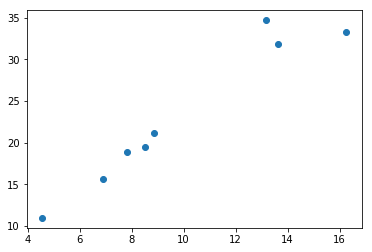

In [191]:
plt.scatter(x.squeeze().numpy(), y.squeeze().numpy())

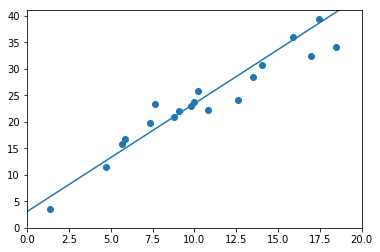

tensor(1.8648122549) tensor(3.0800323486)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:42: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


In [194]:
# 随机初始化参数
w = t.rand(1, 1) 
b = t.zeros(1, 1)

lr =0.001 # 学习率

for ii in range(20000):
    x, y = get_fake_data()
    
    # forward：计算loss
    y_pred = x.mm(w) + b.expand_as(y) # x@W等价于x.mm(w);for python3 only
    loss = 0.5 * (y_pred - y) ** 2 # 均方误差
    loss = loss.sum()
    
    # backward：手动计算梯度
    dloss = 1
    dy_pred = dloss * (y_pred - y)
    
    dw = x.t().mm(dy_pred)
    db = dy_pred.sum()
    
    # 更新参数
    w.sub_(lr * dw)
    b.sub_(lr * db)
    
    if ii%1000 ==0:
       
        # 画图
        display.clear_output(wait=True)
        x = t.arange(0, 20).view(-1, 1)
        y = x.mm(w) + b.expand_as(x)
        plt.plot(x.numpy(), y.numpy()) # predicted
        
        x2, y2 = get_fake_data(batch_size=20) 
        plt.scatter(x2.numpy(), y2.numpy()) # true data
        
        plt.xlim(0, 20)
        plt.ylim(0, 41)
        plt.show()
        plt.pause(0.5)
        
print(w.squeeze()[0], b.squeeze()[0])

可见程序已经基本学出w=2、b=3，并且图中直线和数据已经实现较好的拟合。

虽然上面提到了许多操作，但是只要掌握了这个例子基本上就可以了，其他的知识，读者日后遇到的时候，可以再看看这部份的内容或者查找对应文档。
